In [1]:
import pickle
import torch
import matplotlib.pyplot as plt
import matplotlib
from scipy import stats
import os
import numpy as np
import sys
import pandas as pd 
sys.path.append("../../../..")
from matplotlib.lines import Line2D
from matplotlib.legend_handler import HandlerPatch
import matplotlib.patches as mpatches
from datasets.morpho_mnist.dataset import ImageDataset, MetadataDataset, TripletDataset
from auto_localization.models.BasicVAE import BasicVAE
from auto_localization.experiment_management.basic_experiment import BasicExperiment
from auto_localization.experiment_management.hyperparameter_experiment import HyperparameterExperiment
from auto_localization.dataset_management.data_manager import DataManager
from auto_localization.plotting.localization import save_localization_metadata_distance_plots
from auto_localization.oracles.metadata_oracle import MetadataOracle
from auto_localization.oracles.indexed_metadata_oracle import IndexedMetadataOracle
from auto_localization.training.training_test import reconstruction_of_metadata
from datasets.morpho_mnist.measure import measure_image
from auto_localization.localization.localization_experiment_manager import LocalizationExperimentManager
from auto_localization.plotting.localization import embedding_with_posterior_path, embedding_with_planes
import auto_localization.plotting.localization as localization_plotting
import auto_localization.plotting.image_sampling as image_sampling

In [2]:
"""
    Function that loads a model from a given path.
"""
def load_config(model_dir):
    # load params from model_dir
    with open(model_dir+"/params.pkl", "rb") as f:
        config = pickle.load(f)
   
    return config

In [3]:
model_dir = "../../../logs/deep-forest-7671"
config = load_config(model_dir)
experiment_config = config
experiment_config["trials"] = 5
experiment_config["model_config"]["triplet_beta"] = [0.0, 1.0]
print(experiment_config)

{'trials': 5, 'epochs': 50, 'lr': 0.001, 'batch_size': 512, 'trainer': 'triplet', 'group': 'thickness_slant_localization_5', 'localization_config': {'indexed': False, 'trials': 20, 'k': 1.0, 'localizer_type': ['MCMV', 'Random'], 'num_queries': 50, 'similarity_mode': False}, 'model_config': {'model_type': 'BasicVAE', 'latent_dim': 2, 'in_shape': 32, 'd': 32, 'layer_count': 4, 'channels': 1, 'loss_name': 'VAETripletLoss', 'kl_beta': 0.01, 'triplet_beta': [0.0, 1.0], 'triplet_margin': 1.0, 'warm_start': 30, 'kl_max': 0.01, 'triplet_mining': False}, 'dataset_config': {'dataset_name': 'MorphoMNIST', 'component_weighting': [0.0, 0.0, 3.0, 1.0, 0.0, 0.0], 'localization_component_weighting': [0.0, 0.0, 3.0, 1.0, 0.0, 0.0], 'which_digits': [1], 'one_two_ratio': 0.0, 'batch_size': 512}}


In [4]:
triplet_directory_list = ["brisk-fog-7674", "youthful-water-7673", "peach-resonance-7672", "soft-grass-7676", "super-sun-7675"]
no_triplet_directory_list = ["deep-forest-7671", "brisk-resonance-7670", "glamorous-sun-7669", "smart-sunset-7667", "silvery-plasma-7668"]

In [5]:
def get_final_localization_values(model_dir):
    model_dir = "../../../logs/"+model_dir
    # load up the localizer_metrics
    with open(model_dir+"/localizer_metrics.pkl", "rb") as f:
        localizer_metrics = pickle.load(f)
    # the evens are mcmv and the odds are random
    mcmv_localization_values = []
    # tuples (thickness, slant)
    random_localization_values = []
    # go through each of the set of metrics
    for index, metrics in enumerate(localizer_metrics):
        # get the broken down metrics
        broken_down = metrics["broken_down_metadata_loss"]
        last_broken_down = broken_down[-1]
        thickness = last_broken_down[2]
        slant = last_broken_down[3]
        # get the last value in broken down metrics
        if index % 2 == 0:
            # mcmv
            mcmv_localization_values.append([thickness, slant])
        else:
            # random
            random_localization_values.append([thickness, slant])
            
    return [mcmv_localization_values, random_localization_values]

In [12]:
def list_get_final_localization_values(directory_list):
    final_localization_values = []
    for directory in directory_list:
        loc_vals = get_final_localization_values(directory)
        # mean along mcmv and random axes
        loc_vals = np.mean(loc_vals, axis=1)
        
        final_localization_values.append(loc_vals)
        
    return final_localization_values

In [13]:
# for triplet and not triplet get the final localization values for mcmv and random
triplet_finals = list_get_final_localization_values(triplet_directory_list)
no_triplet_finals = list_get_final_localization_values(no_triplet_directory_list)
# plot the differences for slant and thickness
triplet_finals = np.swapaxes(triplet_finals, 1, 2)
no_triplet_finals = np.swapaxes(no_triplet_finals, 1, 2)
# shape is (trials, feature, loc_method)

(2, 20, 2)
(2, 20, 2)
(2, 20, 2)
(2, 20, 2)
(2, 20, 2)
(2, 20, 2)
(2, 20, 2)
(2, 20, 2)
(2, 20, 2)
(2, 20, 2)
(5, 2, 2)


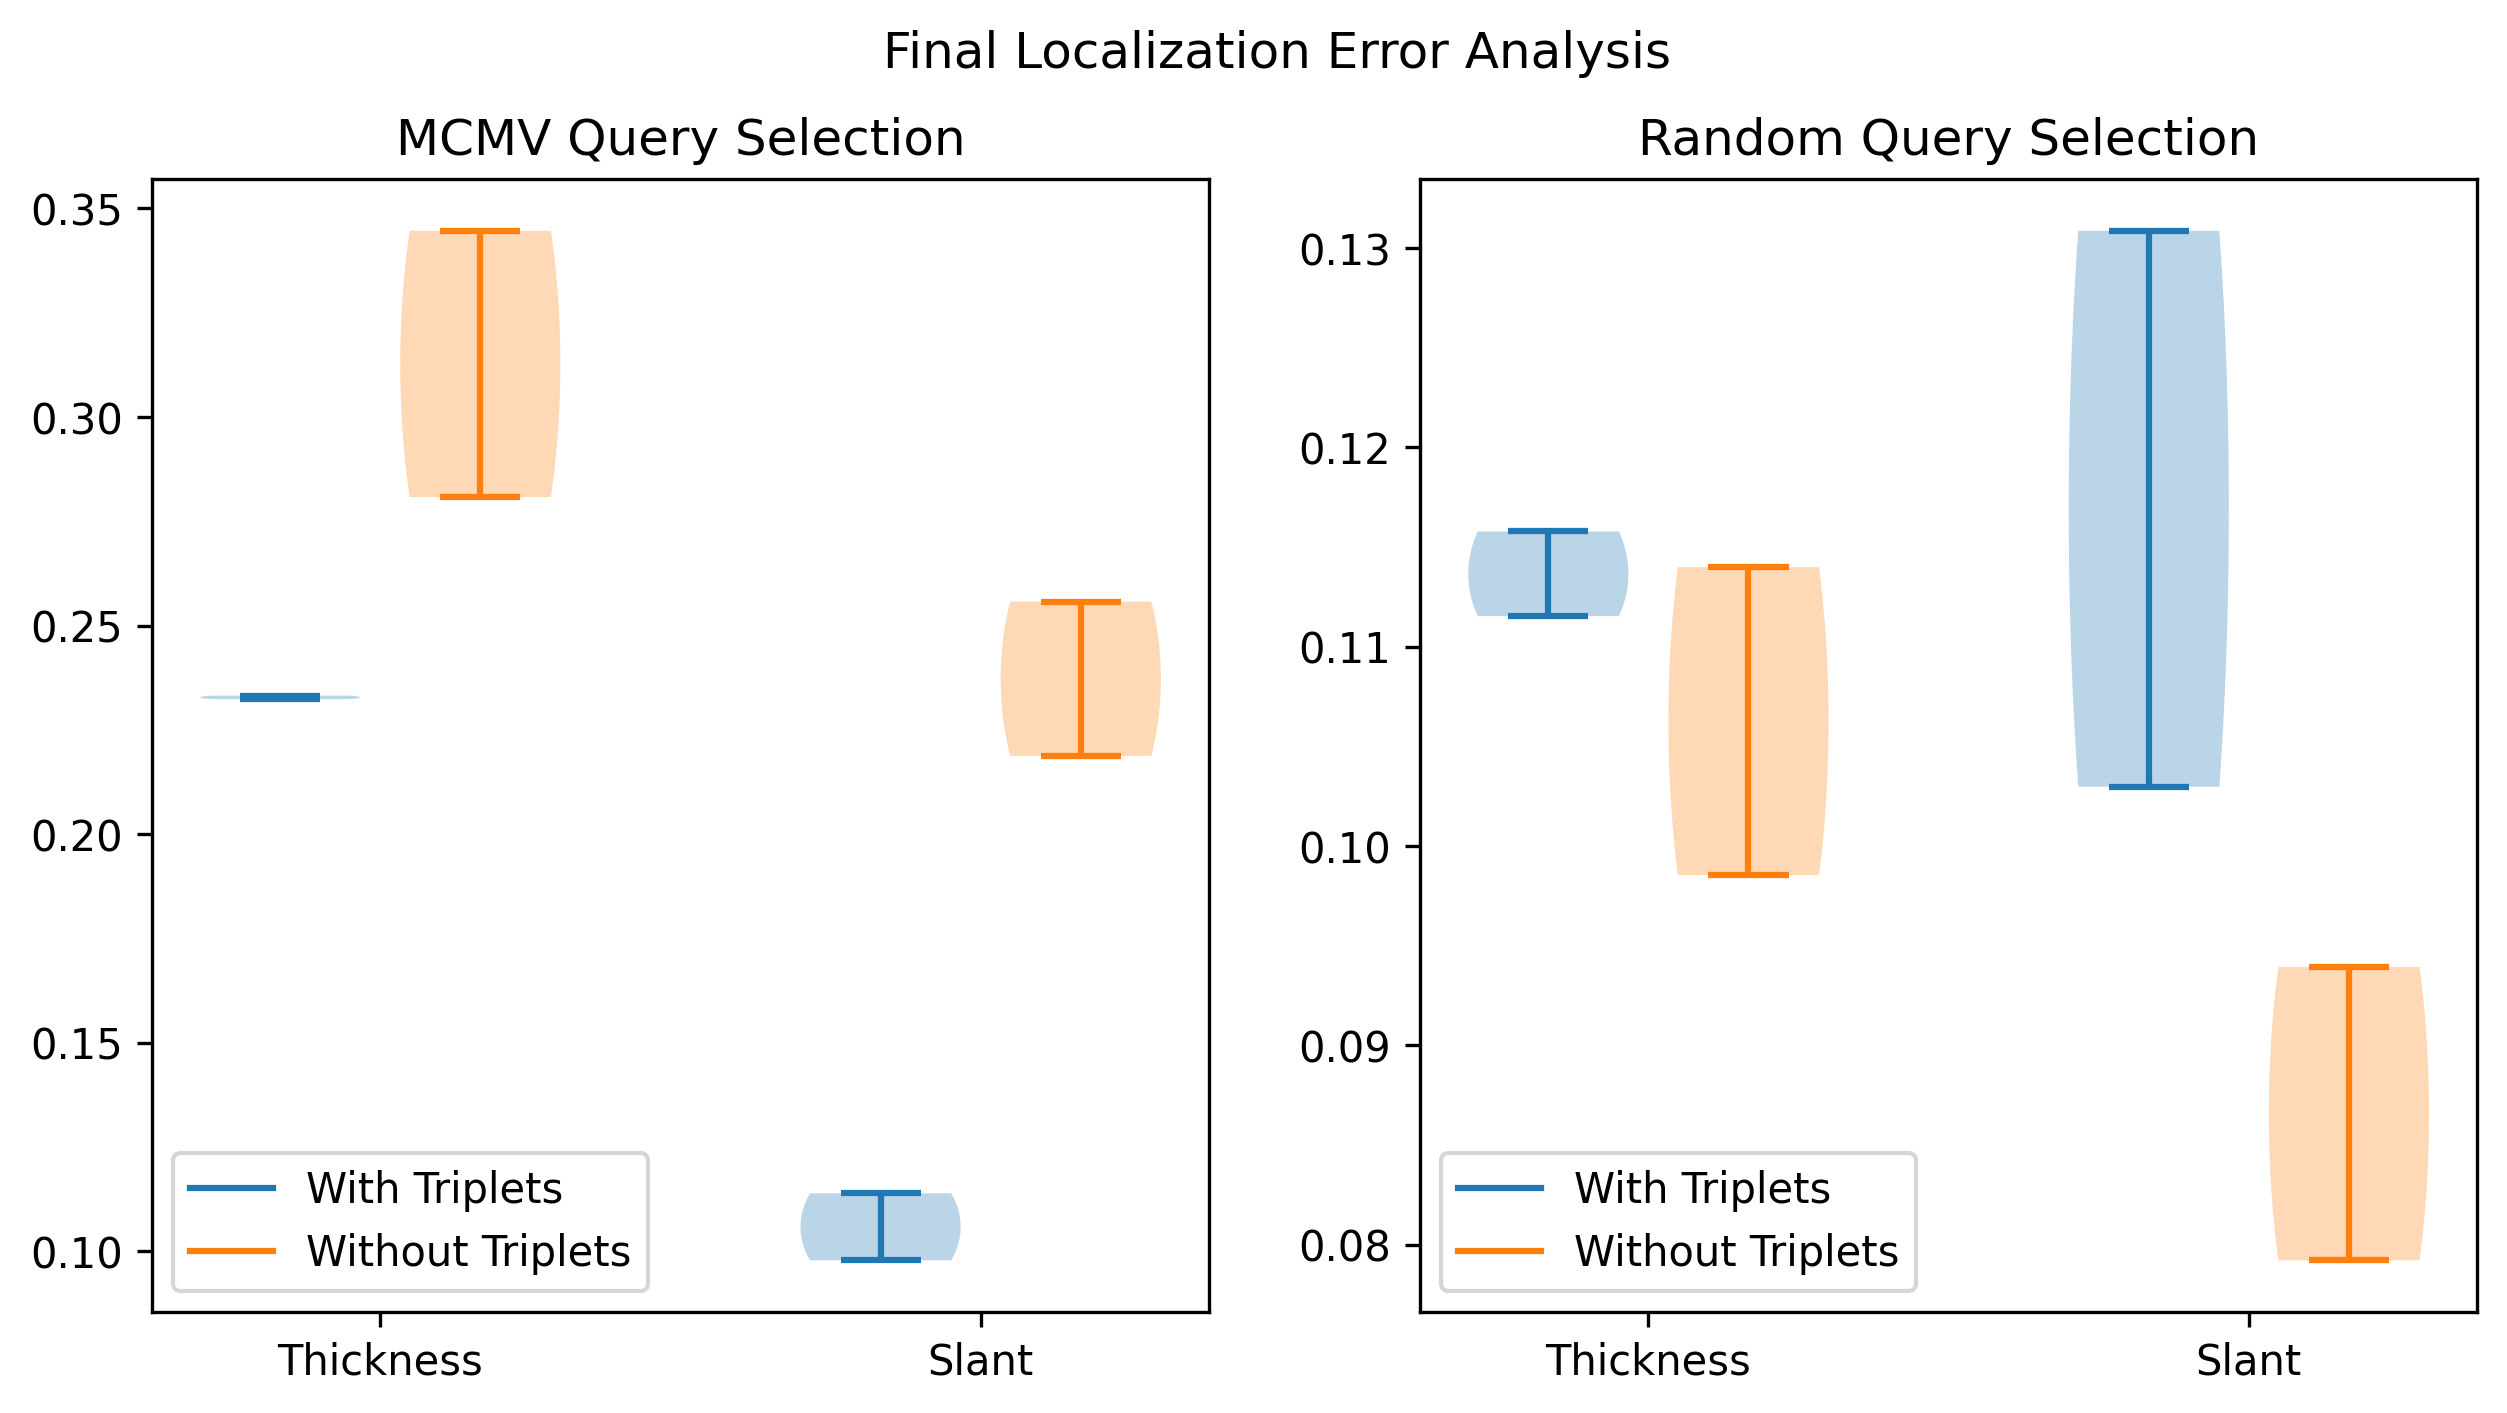

In [14]:
# make the plot
# make the violin plot


# final_rank_correlations is a dictionary that maps
# the model name to a 2D arrays of shape (num_metadata_features, num_trials) 
# holding the final rank correlations
fig, axs = plt.subplots(1, 2, figsize=(10, 5), dpi=300)
feature_names = ["Slant", "Thickness"]
plt.suptitle("Final Localization Error Analysis")
axs[0].set_title("MCMV Query Selection")
xticks = ["Thickness", "Slant"]
xtick_positions = [0.75, 2.25]
axs[0].set_xticks(xtick_positions)
axs[0].set_xticklabels(xticks)
axs[1].set_xticks(xtick_positions)
axs[1].set_xticklabels(xticks)
axs[1].set_title("Random Query Selection")
# make violin plot for the model
# plot thickness mcmv
violin_plot = axs[0].violinplot(triplet_finals[:][0][0], positions=[0.5], widths=0.4)
violin_plot = axs[0].violinplot(no_triplet_finals[:][0][0], positions=[1.0], widths=0.4)
axs[0].set_prop_cycle(None)
# plot slant mcmv
violin_plot = axs[0].violinplot(triplet_finals[:][1][0], positions=[2.0], widths=0.4)
violin_plot = axs[0].violinplot(no_triplet_finals[:][1][0], positions=[2.5], widths=0.4)
# 
axs[0].set_prop_cycle(None)
axs[0].plot([], label="With Triplets")
axs[0].plot([], label="Without Triplets")
axs[0].legend(loc = "lower left")


axs[1].set_prop_cycle(None)
# plot thickness random
violin_plot = axs[1].violinplot(triplet_finals[:][0][1], positions=[0.5], widths=0.4)
violin_plot = axs[1].violinplot(no_triplet_finals[:][0][1], positions=[1.0], widths=0.4)
axs[1].set_prop_cycle(None)
# plot slant random
violin_plot = axs[1].violinplot(triplet_finals[:][1][1], positions=[2.0], widths=0.4)
violin_plot = axs[1].violinplot(no_triplet_finals[:][1][1], positions=[2.5], widths=0.4)
axs[1].set_prop_cycle(None)
axs[1].plot([], label="With Triplets")
axs[1].plot([], label="Without Triplets")

axs[1].legend(loc = "lower left")
plt.show()

### Posterior Volume Analysis
The posterior volume is in some sense a quantification of MCMV's certainty about the location of the ideal point. The posterior volume should monotonically decrease with distance to the mean. The posterior volume should not converge when the posterior mean is away from the latent vector. 

Does the posterior volume converge at a local minimum induced by the metadata metric? Is this local minima at a different location then the latent vector? Is this even a problem? What might be worse is if the posterior volume converges on a local minimum in metadata space that is not the location of the embedded reference

In [31]:
# load up a localizer
# load up the localizer_metrics
with open(model_dir+"/localizers.pkl", "rb") as f:
    localizers = pickle.load(f)
with open(model_dir+"/localizer_metrics.pkl", "rb") as f:
    localizer_metrics = pickle.load(f)
localizer = localizers[4]
localizer_metrics = localizer_metrics[4]

TypeError: unsupported operand type(s) for ** or pow(): 'list' and 'int'

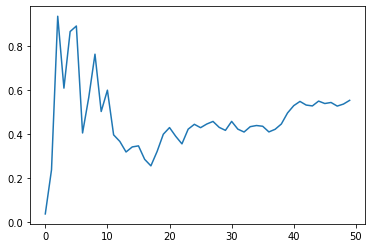

In [40]:
fig, axs = plt.subplots(1, 1)
# plot the latent distance
latent_distance = np.linalg.norm(localizer.embedded_reference - localizer.posterior_means, axis=1) ** 2
plt.plot(latent_distance, label="Latent Distance")
# plot the metadata distance
metadata_loss = localizer_metrics["metadata_loss"] ** 2
plt.plot(metadata_loss, label="Metadata Loss")
# plot the posterior volume
dimensionality = 2
posterior_volume = np.linalg.det(localizer.vars) ** (1 / dimensionality) * dimensionality
plt.plot(posterior_volume, label="Posterior Volume")
plt.legend()

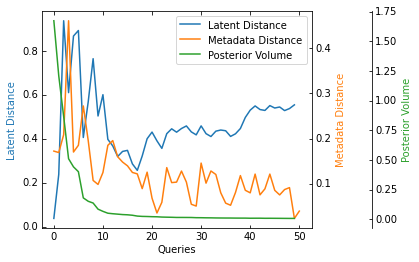

In [41]:
from mpl_toolkits.axes_grid1 import host_subplot
from mpl_toolkits import axisartist
import matplotlib.pyplot as plt

host = host_subplot(111, axes_class=axisartist.Axes)
plt.subplots_adjust(right=0.75)

par1 = host.twinx()
par2 = host.twinx()

par2.axis["right"] = par2.new_fixed_axis(loc="right", offset=(60, 0))

par1.axis["right"].toggle(all=True)
par2.axis["right"].toggle(all=True)

p1, = host.plot(latent_distance, label="Latent Distance")
p2, = par1.plot(metadata_loss, label="Metadata Distance")
p3, = par2.plot(posterior_volume, label="Posterior Volume")


host.set_xlabel("Queries")
host.set_ylabel("Latent Distance")
par1.set_ylabel("Metadata Distance")
par2.set_ylabel("Posterior Volume")

host.legend()

host.axis["left"].label.set_color(p1.get_color())
par1.axis["right"].label.set_color(p2.get_color())
par2.axis["right"].label.set_color(p3.get_color())

plt.show()